# A case-study for applying Survival Analysis on real business problem.
This notebook contains the sample implementation of idea discussed in this article: https://medium.com/vitalify-asia/a-case-study-for-applying-survival-analysis-on-real-business-problem-844e20820a7

The data files in this repo is only a subset of the data used in the example and only serves as an example.

In [2]:
from datetime import date
import datetime
from time import mktime

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
seed = 123

Define some helper functions

In [3]:
def load_base_df():
    df = pd.read_csv('https://raw.githubusercontent.com/vfa-phuclkh/online_retail_survival_analysis/master/input_orig.csv')
    df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], format='%y/%m/%d').astype(int)
    df['Price_down_date'] = pd.to_datetime(df['Price_down_date'], format='%y/%m/%d').astype(int)
    df['Departure_Date'] = pd.to_datetime(df['Departure_Date'], format='%y/%m/%d').astype(int)
    # Remove invalid month. It contains 10 rows.
#     df = df[df['Reg_Month'] != '-']
#     df['Reg_Date'] = df.apply(_make_reg_date, axis=1)
    df = pd.get_dummies(df, drop_first=True, columns=[
        'Color',
        'Country_Sold'
    ])
    df = df.drop([
#         'Reg_Year',
#         'Reg_Month',
    ], axis=1)
#     df = df[df.Publish_period <= 80]
    return df

def _load_data():
    df = load_base_df()

    y = df['Publish_period'].values
    X = df.drop(['Publish_period'], axis=1).values

    return X, y

def list_feature_names():
    df = load_base_df()
    return df.drop(['Publish_period'], axis=1).columns.values

def load_train_data():
    """
    :return: X : train inputs
    :return: y : train labels
    """
    X, y = _load_data()

    y_labels = np.zeros_like(y)
    y_labels[y >= np.percentile(y, 25)] = 1
    y_labels[y >= np.percentile(y, 50)] = 2
    y_labels[y >= np.percentile(y, 75)] = 3

    X_tr, X_test, y_tr, y_test = train_test_split(X, y,
                                                  stratify=y_labels,
                                                  shuffle=True,
                                                  random_state=seed,
                                                  test_size=0.2,
                                                  )

    return X_tr, y_tr, X_test, y_test

In [4]:
X_tr, y_tr, X_test, y_test = load_train_data()

In [5]:
a = X_tr[0][1]
print(datetime.datetime.fromtimestamp(1440115200000000000/1e9).strftime('%y/%m/%d'))
X_tr[0]

15/08/21


array(['XL3-1030422', 1328659200000000000, 1322179200000000000,
       1339113600000000000, 95938, 29, 110000, 60000, 96, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=object)

In [6]:
print(X_tr.shape, X_test.shape)
print("List of all feature names:")
name_list = list_feature_names()
for i in range(name_list.shape[0]):
    print(i, name_list[i])

(80, 25) (20, 25)
List of all feature names:
0 Bike_id
1 Purchase_Date
2 Price_down_date
3 Departure_Date
4 Distance_travelled
5 N_Photos
6 Price_Orig
7 Price_Curr
8 N_Inquires
9 Color_Blue
10 Color_Gray
11 Color_Green
12 Color_Pearl
13 Color_Pink
14 Color_Silver
15 Color_White
16 Country_Sold_Brunei
17 Country_Sold_Burundi
18 Country_Sold_Cambodia
19 Country_Sold_Chile
20 Country_Sold_Indonesia
21 Country_Sold_Laos
22 Country_Sold_Malawi
23 Country_Sold_New Zealand
24 Country_Sold_Vietnam


In [7]:
# Normalize data
from sklearn.preprocessing import normalize
X_tr[:, 1:] = normalize(X_tr[:, 1:], axis=0)
X_test[:, 1:] = normalize(X_test[:, 1:], axis=0)

In [8]:
X_tr.shape

(80, 25)

## Baseline Simple Regression

In [9]:
import lightgbm as lgb
eval_result = {}
params = {
    'bagging_fraction': 0.8351240299610244,
    'feature_fraction': 0.9880900755129445,
    'learning_rate': 0.601638071095316,
    'max_bin': 733,
    'max_depth': 7,
    'num_leaves': 12,
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'verbose': -1,
}

lgb_tr = lgb.Dataset(X_tr[:, 1:], label=y_tr, free_raw_data=False)
lgb_val = lgb.Dataset(X_test[:, 1:], label=y_test, reference=lgb_tr, free_raw_data=False)

model = lgb.train(params,
                  lgb_tr,
                  num_boost_round=2000,
                  valid_sets=lgb_val,
                  early_stopping_rounds=100,
                  evals_result=eval_result,
                  verbose_eval=False)


Mean square error:  309.70242862216566


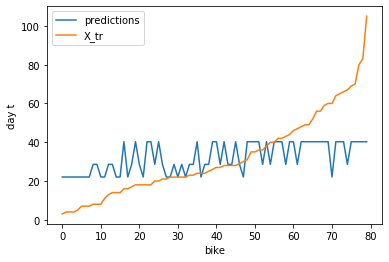

In [10]:

preds = model.predict(X_tr[: ,1:], num_iteration=model.best_iteration)
loss = mean_squared_error(y_tr, preds)
print("Mean square error: ", loss)

sort_y = np.argsort(y_tr)
plt.plot(preds[sort_y], label='predictions')
plt.plot(y_tr[sort_y], label='X_tr')
plt.xlabel('bike')
plt.ylabel('day t')
plt.legend(loc='best')

Mean square error:  237.7930439056094


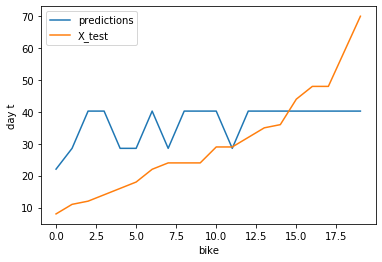

In [11]:
preds = model.predict(X_test[: ,1:], num_iteration=model.best_iteration)
loss = mean_squared_error(y_test, preds)
print("Mean square error: ", loss)

sort_y = np.argsort(y_test)
plt.plot(preds[sort_y], label='predictions')
plt.plot(y_test[sort_y], label='X_test')
plt.xlabel('bike')
plt.ylabel('day t')
plt.legend(loc='best')

Mean square error:  295.3205516788544


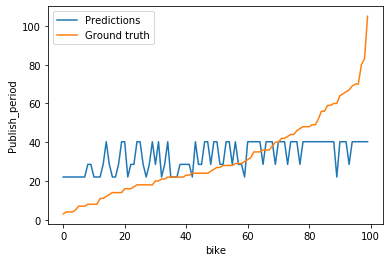

In [12]:
X = np.concatenate([X_tr, X_test], axis=0)
y = np.concatenate([y_tr, y_test], axis=0)

preds = model.predict(X[: ,1:], num_iteration=model.best_iteration)
loss = mean_squared_error(y, preds)
print("Mean square error: ", loss)

sort_y = np.argsort(y)
plt.plot(preds[sort_y], label='Predictions')
plt.plot(y[sort_y], label='Ground truth')
plt.xlabel('bike')
plt.ylabel('Publish_period')
plt.legend(loc='best')

# Survival Analysis

In [13]:
# load survival-format data
df = pd.read_csv('https://raw.githubusercontent.com/vfa-phuclkh/online_retail_survival_analysis/master/input_survival.csv')
df = pd.get_dummies(df, drop_first=True, columns=[
        'Color',
        'Country_Sold'
    ])
X = df.drop(['is_sold', 'Publish_period'], axis=1)
X_values = X.values
# Combine the event indicator isSold and Publish_period to create ground truth y for our model
isSold = df['is_sold'].astype(bool)
pub = df['Publish_period']
y = pd.concat([isSold, pub], axis=1)
y_values = y.values

In [14]:
# Normalize data
from sklearn.preprocessing import normalize
X_values[:, 1:] = normalize(X_values[:, 1:], axis=0)

# train test split
X_tr, X_test, y_tr, y_test = train_test_split(X_values, y_values,
                                                  shuffle=True,
                                                  random_state=seed,
                                                  test_size=0.2,
                                                  )

In [15]:
# Convert y to uncensored data, all are (True, days)
dt = np.dtype([('event', np.bool_), ('days', np.float64)])
def convert_y(y):
    y_out = []
#     y = np.log(y+1e-22)
    for i in range(y.shape[0]):
        if y[i, 0]:
            y_out.append(('True', y[i, 1]))
        else:
            y_out.append(('False', y[i, 1]))
    y_out = np.array(y_out, dtype=dt)
    return y_out

y_converted = convert_y(y_values)

Text(0.5, 0, 'day $t$')

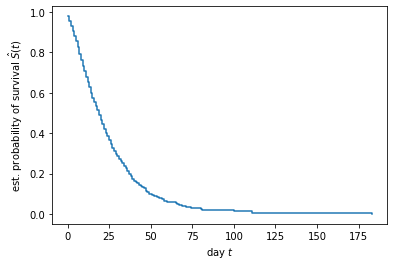

In [16]:
from sksurv.nonparametric import kaplan_meier_estimator

time, sold_prob = kaplan_meier_estimator(y['is_sold'], y['Publish_period'])
plt.step(time, sold_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("day $t$")

72859.14621293319


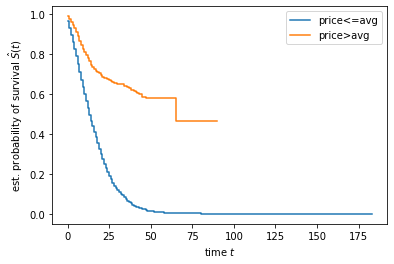

In [17]:
# Use the Price
avg_price = np.mean(X['Price'])
print(avg_price)

mask_price_below = X['Price'] <= avg_price
time, sold_prob_below = kaplan_meier_estimator(
    y['is_sold'][mask_price_below],
    y["Publish_period"][mask_price_below])
plt.step(time, sold_prob_below, where="post", label="price<=avg")

mask_price_above = X['Price'] > avg_price
time, sold_prob_above = kaplan_meier_estimator(
    y['is_sold'][mask_price_above],
    y["Publish_period"][mask_price_above])
plt.step(time, sold_prob_above, where="post", label="price>avg")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

30.794122901036083


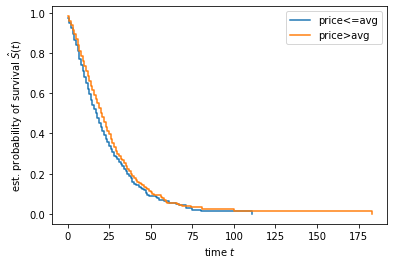

In [18]:
# Use the N_Photos
avg_price = np.mean(X['N_Photos'])
print(avg_price)

mask_price_below = X['N_Photos'] <= avg_price
time, sold_prob_below = kaplan_meier_estimator(
    y['is_sold'][mask_price_below],
    y["Publish_period"][mask_price_below])
plt.step(time, sold_prob_below, where="post", label="price<=avg")

mask_price_above = X['N_Photos'] >= avg_price
time, sold_prob_above = kaplan_meier_estimator(
    y['is_sold'][mask_price_above],
    y["Publish_period"][mask_price_above])
plt.step(time, sold_prob_above, where="post", label="price>avg")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Multivariate Survival Models
#### Train only one of the model below before predict
### CoxPHSurvivalAnalysis
The CoxPHSurvivalAnalysis expects a data matrix and a structered array of survival times and binary event indicators.

In [19]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis(alpha=2e-01, tol=1e-09, n_iter=1000)
estimator.fit(X_values[:, 1:], y_converted)

CoxPHSurvivalAnalysis(alpha=0.2, n_iter=1000, ties='breslow', tol=1e-09,
                      verbose=0)

In [20]:
y

,is_sold,Publish_period
0,False,10
1,True,4
2,True,28
3,False,17
4,True,7
...,...,...
11191,True,2
11192,False,19
11193,True,0
11194,False,7


In [21]:
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import mean_squared_error

def predict_day(pred_survival, prob=0.5):
    days = np.zeros((pred_survival.shape))
    for i, c in enumerate(pred_survival):
        days[i] = c.x[-1]
        for j, prob in enumerate(c.y):
            if prob >= 0.5:
                days[i] = c.x[j]
    return days

def score_survival_model(model, X, y_out):
    y = np.zeros((y_out.shape))
    for i in range(y_out.shape[0]):
        y[i] = y_out[i][1]
    prediction = model.predict_survival_function(X)
    predict_days = predict_day(prediction)
    loss = mean_squared_error(y, predict_days)
    return loss

<Figure size 432x288 with 0 Axes>

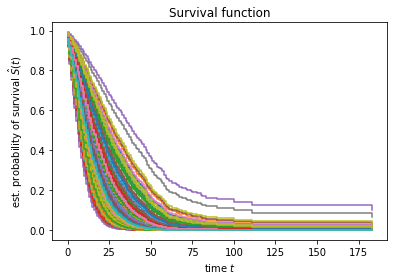

<Figure size 432x288 with 0 Axes>

In [22]:
pred_survival = estimator.predict_survival_function(X_test[:, 1:].astype(float))
for i, c in enumerate(pred_survival):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
# plt.legend(loc="best")
plt.title("Survival function")
plt.figure(0)

In [23]:
predict_days = predict_day(pred_survival)
predict_days

array([11., 13.,  7., ..., 11., 10., 10.])

In [37]:
predict_days

array([11., 13.,  7., ..., 11., 10., 10.])

In [38]:
y_test[:, 1]

array([12, 37, 25, ..., 10, 45, 6], dtype=object)

116.07678571428572

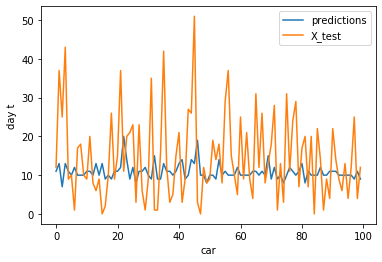

In [39]:
n_test = y_test.shape
plt.plot(predict_days[:100], label='predictions')
plt.plot(y_test[:, 1][:100], label='X_test')
plt.xlabel('car')
plt.ylabel('day t')
plt.legend(loc='best')

loss = mean_squared_error(y_test[:, 1], predict_days)
loss

## Suggest price for maximum profit

In [26]:
# Some import
from time import mktime

import numpy as np
import pandas as pd
from datetime import date
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

In [27]:
COST_PER_DAY = 1000

In [28]:
def calc_profit(df_record, estimator, scaler):
    scaled = scaler.transform(df_record.drop(['Bike_id', 'Publish_period']).values.reshape(1, -1))
    sf = estimator.predict_survival_function([scaled])[0]

    # Interpolation
    f2 = interp1d(sf.x, sf.y, kind='cubic')
    x = np.arange(np.max(sf.x) + 1)
    y = f2(x)

    income = (-np.gradient(y, x) * df_record['Price']).sum()
    outcome = (COST_PER_DAY * y).sum()
    profit = income - outcome

    return profit

def plot_survival(estimator, X, n_plot=-1):
    pred_survival = estimator.predict_survival_function(X)
    for i, c in enumerate(pred_survival[:n_plot]):
        plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title("Survival function")
    plt.show()
    
def optimize_price(estimator, scaler, df_record, max_price, min_price):
    print(df_record)
    price = df_record['Price']
    sp_price = np.linspace(min_price, max_price, 1000)

    profits = []
    for p in sp_price:
        df_record['Price'] = p
        profit = calc_profit(df_record, estimator, scaler)
        profits.append(profit)
    best = np.argmax(profits)
    best_profit = profits[best]
    best_price = sp_price[best]
    print("Suggest price:", best_price)
    print("price:", price)
    plt.plot(sp_price, profits)
    plt.show(block=False)

In [29]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('https://raw.githubusercontent.com/vfa-phuclkh/online_retail_survival_analysis/master/input_survival.csv')
df = pd.get_dummies(df, drop_first=True, columns=[
        'Color',
        'Country_Sold'
    ])
X = df.drop(['is_sold', 'Publish_period'], axis=1)
y = df['Publish_period'].values

ref_tr, ref_val, _, _ = train_test_split(df['Bike_id'].values, y,
#                                          stratify=y_labels,
                                         shuffle=True,
                                         random_state=123,
                                         test_size=0.2,
                                         )
df_tr = df[df['Bike_id'].isin(ref_tr)]
df_val = df[df['Bike_id'].isin(ref_val)]

# Prepare X
scaler = MinMaxScaler().fit(df.drop(['Bike_id', 'Publish_period'], axis=1).values)
X_tr = scaler.transform(df_tr.drop(['Bike_id', 'Publish_period'], axis=1).values)
X_val = scaler.transform(df_val.drop(['Bike_id', 'Publish_period'], axis=1).values)

# Prepare y
y_tr = pd.DataFrame({
    'Survival_in_days': df_tr['Publish_period'].values,
    'Status': np.ones_like(df_tr['Publish_period'].values).astype(bool),
}).to_records(index=False)
y_val = pd.DataFrame({
    'Survival_in_days': df_val['Publish_period'].values,
    'Status': np.ones_like(df_val['Publish_period'].values).astype(bool),
}).to_records(index=False)

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/vfa-phuclkh/online_retail_survival_analysis/master/input_survival.csv')
df = pd.get_dummies(df, drop_first=True, columns=[
        'Color',
        'Country_Sold'
    ])
X = df.drop(['is_sold', 'Publish_period'], axis=1)
X_values = X.values
# Combine the event indicator isSold and Publish_period to create ground truth y for our model
isSold = df['is_sold'].astype(bool)
pub = df['Publish_period']
y = pd.concat([isSold, pub], axis=1)
y_values = y.values

In [31]:
# Prepare X
scaler = MinMaxScaler().fit(df.drop(['Bike_id', 'Publish_period'], axis=1).values)
X_tr = scaler.transform(df_tr.drop(['Bike_id', 'Publish_period'], axis=1).values)
X_val = scaler.transform(df_val.drop(['Bike_id', 'Publish_period'], axis=1).values)

In [32]:
# Fit
estimator = CoxPHSurvivalAnalysis(alpha=3, n_iter=100)
estimator.fit(X_tr, y_tr)

ValueError: elements of event indicator must be boolean, but found int64

In [ ]:
# Plot survival
plot_survival(estimator, X_val, n_plot=10)

In [ ]:
max_price = X['Price'].values.max()
min_price = X['Price'].values.min()

In [ ]:
# Print one sample at index 10
optimize_price(estimator, scaler, df_val.iloc[5], max_price, min_price)